In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import sys
import os
import scipy
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [ ]:
test_data=pd.read_parquet('/content/drive/MyDrive/recipe_kg/recipes.parquet')
print(test_data.shape, test_data.head())
col=list(test_data.columns)
print(col)
test_data.head()
test_data['RecipeId'] = test_data['RecipeId'].astype(object)

(522517, 28)    RecipeId  ...                                 RecipeInstructions
0      38.0  ...  [Toss 2 cups berries with sugar., Let stand fo...
1      39.0  ...  [Soak saffron in warm milk for 5 minutes and p...
2      40.0  ...  [Into a 1 quart Jar with tight fitting lid, pu...
3      41.0  ...  [Drain the tofu, carefully squeezing out exces...
4      42.0  ...  [Mix everything together and bring to a boil.,...

[5 rows x 28 columns]
['RecipeId', 'Name', 'AuthorId', 'AuthorName', 'CookTime', 'PrepTime', 'TotalTime', 'DatePublished', 'Description', 'Images', 'RecipeCategory', 'Keywords', 'RecipeIngredientQuantities', 'RecipeIngredientParts', 'AggregatedRating', 'ReviewCount', 'Calories', 'FatContent', 'SaturatedFatContent', 'CholesterolContent', 'SodiumContent', 'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent', 'RecipeServings', 'RecipeYield', 'RecipeInstructions']


In [ ]:
len(test_data)

522517

### Recipe Csv

In [ ]:
recipe_csv = test_data.drop(['AuthorId','AuthorName','DatePublished','RecipeCategory','Keywords','RecipeIngredientQuantities','RecipeIngredientParts'],axis=1)

In [ ]:
def time_transform(x):
  if x==None:
    return 0
  x = x.replace('PT','')
  x = x.replace('M','')
  l =x.split('H')
  if len(l) == 2:
    times = float(l[0])*60 + float(0 if l[1]=='' else l[1])
  elif len(l) == 1:
    try:
      times = float(l[0])
    except:
      times = 0
  else:
    times = 0
    print(times)
  return times

recipe_csv['CookTime'] = recipe_csv['CookTime'].apply(time_transform)
recipe_csv['CookTime'].astype(int)
recipe_csv['PrepTime'] = recipe_csv['PrepTime'].apply(time_transform)
recipe_csv['PrepTime'].astype(int)
recipe_csv['TotalTime'] = recipe_csv['TotalTime'].apply(time_transform)
recipe_csv['TotalTime'].astype(int)

recipe_csv[':LABEL']='recipe'
recipe_csv

,RecipeId,Name,CookTime,PrepTime,TotalTime,Description,Images,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions,:LABEL
0,38,Low-Fat Berry Blue Frozen Dessert,1440.0,45.0,1485.0,Make and share this Low-Fat Berry Blue Frozen ...,[https://img.sndimg.com/food/image/upload/w_55...,4.5,4.0,170.9,2.5,1.3,8.0,29.8,37.1,3.6,30.2,3.2,4.0,None,"[Toss 2 cups berries with sugar., Let stand fo...",recipe
1,39,Biryani,25.0,240.0,265.0,Make and share this Biryani recipe from Food.com.,[https://img.sndimg.com/food/image/upload/w_55...,3.0,1.0,1110.7,58.8,16.6,372.8,368.4,84.4,9.0,20.4,63.4,6.0,None,[Soak saffron in warm milk for 5 minutes and p...,recipe
2,40,Best Lemonade,5.0,30.0,35.0,This is from one of my first Good House Keepi...,[https://img.sndimg.com/food/image/upload/w_55...,4.5,10.0,311.1,0.2,0.0,0.0,1.8,81.5,0.4,77.2,0.3,4.0,None,"[Into a 1 quart Jar with tight fitting lid, pu...",recipe
3,41,Carina's Tofu-Vegetable Kebabs,20.0,1440.0,1460.0,This dish is best prepared a day in advance to...,[https://img.sndimg.com/food/image/upload/w_55...,4.5,2.0,536.1,24.0,3.8,0.0,1558.6,64.2,17.3,32.1,29.3,2.0,4 kebabs,"[Drain the tofu, carefully squeezing out exces...",recipe
4,42,Cabbage Soup,30.0,20.0,50.0,Make and share this Cabbage Soup recipe from F...,[https://img.sndimg.com/food/image/upload/w_55...,4.5,11.0,103.6,0.4,0.1,0.0,959.3,25.1,4.8,17.7,4.3,4.0,None,"[Mix everything together and bring to a boil.,...",recipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522512,541379,Meg's Fresh Ginger Gingerbread,35.0,60.0,95.0,Make and share this Meg's Fresh Ginger Gingerb...,[],NaN,NaN,316.6,12.5,7.6,54.4,278.2,48.5,0.8,22.8,3.9,8.0,1 8x8 cake pan,[Preheat oven to 350&deg;F Grease an 8x8 cake ...,recipe
522513,541380,Roast Prime Rib au Poivre with Mixed Peppercorns,180.0,30.0,210.0,"White, black, green, and pink peppercorns add ...",[https://img.sndimg.com/food/image/upload/w_55...,NaN,NaN,2063.4,172.4,71.4,433.8,766.3,3.2,0.7,0.1,117.0,8.0,1 Roast,[Position rack in center of oven and preheat t...,recipe
522514,541381,Kirshwasser Ice Cream,180.0,60.0,240.0,Make and share this Kirshwasser Ice Cream reci...,[],NaN,NaN,1271.3,117.2,72.6,470.9,192.5,33.9,0.0,17.3,12.8,6.0,None,[heat half and half and heavy cream to a simme...,recipe
522515,541382,Quick & Easy Asian Cucumber Salmon Rolls,0.0,15.0,15.0,"Extremely quick and easy to make, these are gr...",[https://img.sndimg.com/food/image/upload/w_55...,NaN,NaN,16.1,0.6,0.1,2.9,100.5,0.3,0.0,0.1,2.4,NaN,20 rolls,"[In a small bowl, combine mayo and wasabi past...",recipe


In [ ]:
recipe_csv.to_csv('/content/drive/MyDrive/IRSProjectSharedFolder/neo4j_import_csv/recipe.csv',index=None,header=None)

In [ ]:
columns_l = list(recipe_csv.columns.values)
dtypes_l = list(recipe_csv.dtypes.values)
new_df = {}
i = 0
for c,t in zip(columns_l,dtypes_l):
  c = str(c)
  t = str(t)
  if t == 'float64':
    t = ':float'
  else:
    t = ''
  if i == 0:
    t = ':ID'
  elif i == len(columns_l)-1:
    t = ':LABEL'
    c = ''

  new_df[c+t] = None
  i += 1
new_df = pd.DataFrame(new_df,columns=new_df.keys())
new_df
new_df.to_csv('/content/drive/MyDrive/IRSProjectSharedFolder/neo4j_import_csv/recipe_header.csv',index=None)

### Ingredients csv

In [ ]:
ingre_set = set()
def get_ingre(x):
  x = list(x)
  for i in x:
    ingre_set.add(i)
  return x
test_data['RecipeIngredientParts'].apply(get_ingre)
len(ingre_set)
# recipe_id_max = test_data['RecipeId'].max()
# ids = []
# names = []
# for name,id in zip(list(ingre_set),range(int(recipe_id_max)+1,int(recipe_id_max)+2+len(ingre_set))):
#   ids.append(id)
#   names.append(name)

# ingre_csv = pd.DataFrame({':ID':ids,':Name':names},columns=[':ID',':Name'])
ingre_csv = pd.DataFrame({':ID':list(ingre_set),'Name':list(ingre_set)},columns=[':ID','Name'])
ingre_csv[':LABEL'] = 'ingredient'

In [ ]:
ingre_csv.to_csv('/content/drive/MyDrive/IRSProjectSharedFolder/neo4j_import_csv/ingredients.csv',index=None)

### Ingredients-Recipe


In [ ]:
START_ID = []
END_ID = []
Quantities = []
def transform_single_number(x):
  x = x.replace(' ','')
  ql = x.split('⁄')
  if len(ql) == 2:
      return float(ql[0])/float(ql[1])
  else:
    return float(x)


def get_ingre_rela(row):
  rid = row['RecipeId']
  for q,ingre in zip(list(row['RecipeIngredientQuantities']),list(row['RecipeIngredientParts'])):
    try:
      START_ID.append(rid)
      END_ID.append(ingre)
      if q == None:
        result = None
      else:
        ql = q.split('-')
        if len(ql) == 2:
          result = (transform_single_number(ql[0])+transform_single_number(ql[1]))/2
        else:
          result = transform_single_number(q)
      Quantities.append(result)
    except Exception as e:
      print(e)
      print(q)
test_data[['RecipeId','RecipeIngredientQuantities','RecipeIngredientParts']].apply(get_ingre_rela,axis=1)


0         None
1         None
2         None
3         None
4         None
          ... 
522512    None
522513    None
522514    None
522515    None
522516    None
Length: 522517, dtype: object

In [ ]:
ingre_recipe_csv = pd.DataFrame({':START_ID':START_ID,':END_ID':END_ID,'Quantities':Quantities},columns=[':START_ID',':END_ID','Quantities'])
ingre_recipe_csv[':TYPE'] = 'Has_Ingredient'
ingre_recipe_csv[':START_ID'] = ingre_recipe_csv[':START_ID'].astype(object)
ingre_recipe_csv

,:START_ID,:END_ID,Quantities,:TYPE
0,38,blueberries,4.00,Has_Ingredient
1,38,granulated sugar,0.25,Has_Ingredient
2,38,vanilla yogurt,1.00,Has_Ingredient
3,38,lemon juice,1.00,Has_Ingredient
4,39,saffron,1.00,Has_Ingredient
...,...,...,...,...
4102924,541383,panko breadcrumbs,0.25,Has_Ingredient
4102925,541383,Worcestershire sauce,1.00,Has_Ingredient
4102926,541383,flour,2.00,Has_Ingredient
4102927,541383,panko breadcrumbs,0.50,Has_Ingredient


In [ ]:
ingre_recipe_csv.dtypes

:START_ID     float64
:END_ID        object
Quantities    float64
:TYPE          object
dtype: object

In [ ]:
ingre_recipe_csv.to_csv('/content/drive/MyDrive/IRSProjectSharedFolder/neo4j_import_csv/ingredients_recipe.csv',index=None,header=None)

In [ ]:
ingre_recipe_header_csv=ingre_recipe_csv.drop(index=ingre_recipe_csv.index)
ingre_recipe_header_csv

,:START_ID,:END_ID,Quantities,:TYPE


In [ ]:
ingre_recipe_header_csv.to_csv('/content/drive/MyDrive/IRSProjectSharedFolder/neo4j_import_csv/ingredients_recipe_header.csv',index=None)

### main ingredients

In [ ]:
ingre_set = set()
def get_ingre(x):
  x = list(x)
  for i in x:
    ingre_set.add(i)
  return x
test_data['RecipeIngredientParts'].apply(get_ingre)
len(ingre_set)

7368

In [ ]:
import pickle as pk
main2sub = pk.load(open('/content/drive/MyDrive/IRSProjectSharedFolder/align_name/main2sub.pickle','rb'))
sub2main = {}
for main_ingre in main2sub:
  for sub_in in main2sub[main_ingre]:
    sub2main[sub_in] = main_ingre

print(sub2main)

{'australian sweet apple chutney': 'Apple', 'apple ring': 'Apple', 'tart baking apple': 'Apple', 'braeburn apples': 'Apple', 'braeburn apple': 'Apple', 'sweet apple cider': 'Apple', 'apples': 'Apple', 'green apples': 'Apple', 'dry apple cider': 'Apple', 'tart baking apples': 'Apple', 'brown apple vinegar': 'Apple', 'fuji apples': 'Apple', 'winesap apple': 'Apple', 'yellow apples': 'Apple', 'cracker barrel fried apples': 'Apple', 'dutch apples': 'Apple', 'rome apples': 'Apple', 'apple': 'Apple', 'yellow apple': 'Apple', 'green apple': 'Apple', 'fuji apple': 'Apple', 'tart dessert apple': 'Apple', 'stayman apples': 'Apple', 'pie apples': 'Apple', 'sliced apples': 'Apple', 'apple butter': 'Apple', 'apple brandy': 'Apple', 'crisp red apples': 'Apple', 'tart green apple': 'Apple', 'cooking apples': 'Apple', 'heinz apple cider vinegar': 'Apple', 'pippin apple': 'Apple', "drunken apples - like famous dave's": 'Apple', 'sparkling apple cider': 'Apple', 'jonathan apples': 'Apple', 'mcintosh app

In [ ]:
main_ingre = list(main2sub.keys())
main_ingre = [i.upper() for i in main_ingre]
main_ingre_csv = pd.DataFrame({':ID':main_ingre,'Name':main_ingre},columns=[':ID','Name'])
main_ingre_csv[':LABEL'] = 'main_ingredient'
main_ingre_csv.to_csv('/content/drive/MyDrive/IRSProjectSharedFolder/neo4j_import_csv/main_ingredients.csv',index=None)

In [ ]:
sub_ingre_r = []
main_ingre_r = []
for sub in sub2main:
  sub_ingre_r.append(sub)
  main_ingre_r.append(sub2main[sub].upper())

sub_main_ingre_csv = pd.DataFrame({':START_ID':sub_ingre_r,':END_ID':main_ingre_r},columns=[':START_ID',':END_ID'])
sub_main_ingre_csv[':TYPE'] = 'Belong_Main_Ingredient'

In [ ]:
sub_main_ingre_csv

,:START_ID,:END_ID,:TYPE
0,australian sweet apple chutney,APPLE,Belong_Main_Ingredient
1,apple ring,APPLE,Belong_Main_Ingredient
2,tart baking apple,APPLE,Belong_Main_Ingredient
3,braeburn apples,APPLE,Belong_Main_Ingredient
4,braeburn apple,APPLE,Belong_Main_Ingredient
...,...,...,...
3541,icing sugar,VANILLA,Belong_Main_Ingredient
3542,chocolate curls,VANILLA,Belong_Main_Ingredient
3543,fat free vanilla ice cream,VANILLA,Belong_Main_Ingredient
3544,bittersweet chocolate chips,VANILLA,Belong_Main_Ingredient


In [ ]:
sub_main_ingre_csv.to_csv('/content/drive/MyDrive/IRSProjectSharedFolder/neo4j_import_csv/sub_main_ingre.csv',index=None)

### add meal_type vegetable/vegan/Meat/breakfast/Lunch_Snacks/Beverages/Dessert/One Dish Meal/Quick Breads

---



In [ ]:
dict(test_data['RecipeCategory'].value_counts())

{'< 15 Mins': 6662,
 '< 30 Mins': 9020,
 '< 4 Hours': 4969,
 '< 60 Mins': 9719,
 'African': 267,
 'Apple': 1287,
 'Apple Pie': 1,
 'Artichoke': 62,
 'Asian': 2196,
 'Australian': 381,
 'Austrian': 28,
 'Avocado': 121,
 'Baking': 20,
 'Bar Cookie': 7029,
 'Bass': 141,
 'Bath/Beauty': 650,
 'Bean Soup': 3,
 'Beans': 5463,
 'Bear': 12,
 'Beef Liver': 9,
 'Beef Organ Meats': 179,
 'Beginner Cook': 191,
 'Belgian': 13,
 'Berries': 508,
 'Beverages': 16076,
 'Birthday': 23,
 'Black Bean Soup': 1,
 'Black Beans': 1325,
 'Brazilian': 52,
 'Bread Machine': 10,
 'Bread Pudding': 1,
 'Breads': 12804,
 'Breakfast': 21101,
 'Breakfast Casseroles': 1,
 'Breakfast Eggs': 3,
 'Broccoli Soup': 1,
 'Broil/Grill': 81,
 'Brown Rice': 722,
 'Brunch': 598,
 'Buttermilk Biscuits': 1,
 'Cajun': 462,
 'Cambodian': 13,
 'Camping': 43,
 'Canadian': 415,
 'Candy': 5229,
 'Canning': 38,
 'Cantonese': 57,
 'Caribbean': 230,
 'Catfish': 304,
 'Cauliflower': 1398,
 'Chard': 118,
 'Cheese': 8462,
 'Cheesecake': 3915,


In [ ]:
meal_type = test_data[['RecipeId','Name','RecipeCategory','Keywords']]
meal_type

,RecipeId,Name,RecipeCategory,Keywords
0,38,Low-Fat Berry Blue Frozen Dessert,Frozen Desserts,"[Dessert, Low Protein, Low Cholesterol, Health..."
1,39,Biryani,Chicken Breast,"[Chicken Thigh & Leg, Chicken, Poultry, Meat, ..."
2,40,Best Lemonade,Beverages,"[Low Protein, Low Cholesterol, Healthy, Summer..."
3,41,Carina's Tofu-Vegetable Kebabs,Soy/Tofu,"[Beans, Vegetable, Low Cholesterol, Weeknight,..."
4,42,Cabbage Soup,Vegetable,"[Low Protein, Vegan, Low Cholesterol, Healthy,..."
...,...,...,...,...
522512,541379,Meg's Fresh Ginger Gingerbread,Dessert,[< 4 Hours]
522513,541380,Roast Prime Rib au Poivre with Mixed Peppercorns,Very Low Carbs,"[High Protein, High In..., < 4 Hours]"
522514,541381,Kirshwasser Ice Cream,Ice Cream,"[Dessert, < 4 Hours]"
522515,541382,Quick & Easy Asian Cucumber Salmon Rolls,Canadian,"[< 15 Mins, Easy]"


In [ ]:

type_list = ['vegetable','vegan','Meat','breakfast','Lunch','Beverages','Dessert','One Dish Meal','Quick Breads']
# type_list = ['Dessert','vegetable']
def extract_key(x):
  x = list(x)    
  result_list = [False for i in range(len(type_list))]
  if x == [None]:
    return result_list
  for ingre in x:
    for i,tp in enumerate(type_list):
      if tp.lower() in ingre.lower():
        result_list[i] = True
  return result_list 
meal_type['vegetable'],meal_type['vegan'],meal_type['Meat'],meal_type['breakfast'],meal_type['Lunch or Snacks'],meal_type['Beverages'],meal_type['Dessert'],meal_type['One Dish Meal'],meal_type['Quick Breads'] = zip(*meal_type['Keywords'].apply(extract_key))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
meal_type

,RecipeId,Name,RecipeCategory,Keywords,vegetable,vegan,Meat,breakfast,Lunch or Snacks,Beverages,Dessert,One Dish Meal,Quick Breads
0,38,Low-Fat Berry Blue Frozen Dessert,Frozen Desserts,"[Dessert, Low Protein, Low Cholesterol, Health...",False,False,False,False,False,False,True,False,False
1,39,Biryani,Chicken Breast,"[Chicken Thigh & Leg, Chicken, Poultry, Meat, ...",False,False,True,False,False,False,False,False,False
2,40,Best Lemonade,Beverages,"[Low Protein, Low Cholesterol, Healthy, Summer...",False,False,False,False,False,False,False,False,False
3,41,Carina's Tofu-Vegetable Kebabs,Soy/Tofu,"[Beans, Vegetable, Low Cholesterol, Weeknight,...",True,False,False,False,False,False,False,False,False
4,42,Cabbage Soup,Vegetable,"[Low Protein, Vegan, Low Cholesterol, Healthy,...",False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
522512,541379,Meg's Fresh Ginger Gingerbread,Dessert,[< 4 Hours],False,False,False,False,False,False,False,False,False
522513,541380,Roast Prime Rib au Poivre with Mixed Peppercorns,Very Low Carbs,"[High Protein, High In..., < 4 Hours]",False,False,False,False,False,False,False,False,False
522514,541381,Kirshwasser Ice Cream,Ice Cream,"[Dessert, < 4 Hours]",False,False,False,False,False,False,True,False,False
522515,541382,Quick & Easy Asian Cucumber Salmon Rolls,Canadian,"[< 15 Mins, Easy]",False,False,False,False,False,False,False,False,False


In [ ]:
mt_list = ['vegetable','vegan','Meat','breakfast','Lunch or Snacks','Beverages','Dessert','One Dish Meal','Quick Breads']
def creat_mt_df(mt_name):
  mt = meal_type[meal_type[mt_name]==True].copy()
  mt[':START_ID'] = mt['RecipeId']
  mt[':END_ID'] = mt_name
  return mt[[':START_ID',':END_ID']]

pd_list = []
for i in mt_list:
  pd_list.append(creat_mt_df(i))

In [ ]:
recipe_meal_type = pd.concat(pd_list,axis=0)
recipe_meal_type

,:START_ID,:END_ID
3,41,vegetable
16,54,vegetable
20,58,vegetable
24,62,vegetable
51,91,vegetable
...,...,...
507654,526132,Quick Breads
508615,527100,Quick Breads
518141,536810,Quick Breads
519561,538255,Quick Breads


In [ ]:
recipe_meal_type[':TYPE'] = 'Has_Meal_Type'

In [ ]:
recipe_meal_type_header_csv=recipe_meal_type.drop(index=recipe_meal_type.index)
recipe_meal_type_header_csv

,:START_ID,:END_ID,:TYPE


In [ ]:
recipe_meal_type_header_csv.to_csv('/content/drive/MyDrive/IRSProjectSharedFolder/neo4j_import_csv/recipe_meal_type_header.csv',index=None)

In [ ]:
recipe_meal_type.to_csv('/content/drive/MyDrive/IRSProjectSharedFolder/neo4j_import_csv/recipe_meal_type.csv',index=None,header=None)

In [ ]:
mt_df = pd.DataFrame({':ID':mt_list,'Name':mt_list,':LABEL':'meal_type'})

In [ ]:
mt_df

,:ID,Name,:LABEL
0,vegetable,vegetable,meal_type
1,vegan,vegan,meal_type
2,Meat,Meat,meal_type
3,breakfast,breakfast,meal_type
4,Lunch or Snacks,Lunch or Snacks,meal_type
5,Beverages,Beverages,meal_type
6,Dessert,Dessert,meal_type
7,One Dish Meal,One Dish Meal,meal_type
8,Quick Breads,Quick Breads,meal_type


In [ ]:
mt_df.to_csv('/content/drive/MyDrive/IRSProjectSharedFolder/neo4j_import_csv/meal_type.csv',index=None)

### cuisine type

#### for those having geo-cuisine type, use original geo-key_word (Using w2v+Kmeans to extract geo-keyword)

In [ ]:
import random

keywords_set = set()
segment_sen = []
def append_ingre_sen(x):
  sen_orig = list(x)
  sentences = []
  if sen_orig == [None]:
    return x
  for w in sen_orig:
    keywords_set.add(w.lower().replace('/',' ').replace('.','').replace('(','').replace(')',''))
    w = w.lower().replace('/',' ').replace('.','').replace('(','').replace(')','').split(' ')
    sentences.extend(w)
  # print(sentences)
  segment_sen.append(sentences)
  return x
test_data['Keywords'] = test_data['Keywords'].apply(append_ingre_sen)
print(keywords_set)
print(segment_sen[:5])

{'gumbo', 'halloween cocktail', 'eggs breakfast', 'poultry', 'curries', 'chicken stew', 'birthday', 'small appliance', 'pork', 'peruvian', 'chinese', 'german', 'szechuan', 'pasta shells', 'roast', 'southwest asia middle east', 'brazilian', 'spreads', 'lebanese', 'spaghetti', 'cabbage', 'squid', 'finnish', 'chard', 'costa rican', 'moroccan', 'asian', 'rabbit', 'cheesecake', 'collard greens', 'raspberries', 'pakistani', 'white rice', 'ecuadorean', 'berries', 'cookie & brownie', 'beef organ meats', 'melons', 'stove top', 'soy tofu', 'strawberry', 'catfish', 'deep fried', 'tropical fruits', 'chowders', 'breads', 'pheasant', 'christmas', 'broil grill', 'pasta elbow', 'bean soup', 'kosher', 'smoothies', 'potluck', 'iraqi', 'camping', 'caribbean', 'indian', 'sudanese', '< 15 mins', 'plums', 'duck', 'pineapple', 'malaysian', 'beef kidney', 'served hot new years', 'whole chicken', 'toddler friendly', 'lemon', 'turkey breasts', 'whole turkey', 'japanese', 'swiss', 'egyptian', 'belgian', 'easy', 

In [ ]:
%cd /content/sample_data
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
!gzip -d GoogleNews-vectors-negative300.bin.gz

/content/sample_data
--2021-10-01 13:31:28--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.174.32
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.174.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  34.3MB/s    in 47s     

2021-10-01 13:32:15 (33.1 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [ ]:
from gensim.models import KeyedVectors
model_google = KeyedVectors.load_word2vec_format("/content/sample_data/GoogleNews-vectors-negative300.bin",binary = True)

In [ ]:
from gensim.models import Word2Vec

model = Word2Vec( size=300, window=5, min_count=1, workers=4)
model.build_vocab(segment_sen)
model.intersect_word2vec_format('/content/sample_data/GoogleNews-vectors-negative300.bin', lockf=1.0, binary=True)


In [ ]:
from sklearn.cluster import KMeans
import numpy as np

In [ ]:
vocab_dict = {k:model.wv[k] for k, v in model.wv.vocab.items()}
print('len(vocab_dict)',len(vocab_dict))
start_word = [['Chinese','German','African','Canadian','southwestern','honduran'],['Apple','Strawberry','Melons'],['Chicken','Meat','beef','fish'],['Breakfast','Summer','Winter','Lunch','Thanksgiving','christmas','holiday'],['Healthy','Easy','Low Protein','vegan','homeopathy remedies'],
              ['< 30 Mins','hours','mins'],['Snacks','Sauce','Sauces'],['microwave','stove'],['grains','rice','breads']]
cluster_name = ['region','fruits or vegatables','meat','dine timing','type','required time','snacks or sauce','cook machine','main food']
startpts = [np.mean([np.sum([vocab_dict[i] for i in w.lower().split(' ')],axis=0) for w in l],axis=0) for l in start_word]
startpts = np.stack(startpts,axis=0)
alldts = [np.sum([vocab_dict[i] for i in k.split(' ')],axis=0) for k in keywords_set]
alldts = np.stack(alldts,axis=0)

id2kw = {i:k for i,k in enumerate(keywords_set)}

geo_kw = []
KM= KMeans(n_clusters=len(start_word), init=startpts, n_init=1)
KM.fit(alldts)
for i,e in enumerate(list(KM.labels_)):
  if cluster_name[e] == 'region':
    geo_kw.append(id2kw[i])
  # print(id2kw[i],'——',cluster_name[e])
geo_kw

len(vocab_dict) 364


['chinese',
 'german',
 'southwest asia middle east',
 'brazilian',
 'lebanese',
 'finnish',
 'costa rican',
 'moroccan',
 'asian',
 'pakistani',
 'christmas',
 'iraqi',
 'caribbean',
 'indian',
 'malaysian',
 'japanese',
 'swiss',
 'egyptian',
 'belgian',
 'native american',
 'hawaiian',
 'scottish',
 'spanish',
 'korean',
 'welsh',
 'filipino',
 'south american',
 'indonesian',
 'swedish',
 'european',
 'australian',
 'norwegian',
 'danish',
 'tex mex',
 'chinese new year',
 'thai',
 'ethiopian',
 'african',
 'creole',
 'turkish',
 'czech',
 'nigerian',
 'portuguese',
 'new zealand',
 'pennsylvania dutch',
 'cajun',
 'south african',
 'puerto rican',
 'austrian',
 'dutch',
 'greek',
 'vietnamese',
 'hungarian',
 'palestinian',
 'cuban',
 'canadian',
 'georgian',
 'russian',
 'mexican']

In [ ]:
def has_keyword(x):
  x = list(x)
  if x == [None]:
    return None
  for k in x:
    if k.lower() in geo_kw:
      return k
  return None

cuisine_df = test_data[['RecipeId','Name','Keywords']].copy()
cuisine_df['cuisine_type'] = cuisine_df['Keywords'].apply(has_keyword)
cuisine_df[~cuisine_df['cuisine_type'].isnull()]

,RecipeId,Name,Keywords,cuisine_type
1,39,Biryani,"[Chicken Thigh & Leg, Chicken, Poultry, Meat, ...",Asian
8,46,A Jad - Cucumber Pickle,"[Thai, Asian, Free Of..., < 30 Mins]",Thai
11,49,Chicken Breasts Lombardi,"[Chicken, Poultry, Meat, European, Very Low Ca...",European
12,50,Biscotti Di Prato,"[Cookie & Brownie, European, Weeknight, Oven, ...",European
17,55,Betty Crocker's Southwestern Guacamole Dip,"[Mexican, Low Protein, Low Cholesterol, Health...",Mexican
...,...,...,...,...
522474,541341,PAD THAI NOODLES,"[Asian, Weeknight, < 30 Mins, Easy]",Asian
522475,541342,Teepi Gavvalu,"[Indian, < 60 Mins]",Indian
522481,541348,Chimichurri Grilling Rub,"[Meat, South American, < 30 Mins, For Large Gr...",South American
522492,541359,"Beef, Lamb &amp; Venison Meatballs","[European, < 4 Hours]",European


#### use NN model to predict the cuisine type for those whose cuisine type is not sure

In [ ]:
train_data=pd.read_json('/content/drive/MyDrive/IRSProjectSharedFolder/train.json')
train_data.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


In [ ]:
test_data=pd.read_parquet('/content/drive/MyDrive/recipe_kg/recipes.parquet')
print(test_data.shape, test_data.head())
col=list(test_data.columns)
print(col)

# test_data=test_data[['RecipeCategory', 'RecipeId', 'RecipeIngredientParts','Name']]
test_data['ingredients']=test_data['RecipeIngredientParts']
test_data=test_data.drop(columns='RecipeIngredientParts')
test_data.head()

(522517, 28)    RecipeId  ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

,RecipeId,Name,AuthorId,AuthorName,CookTime,PrepTime,TotalTime,DatePublished,Description,Images,RecipeCategory,Keywords,RecipeIngredientQuantities,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions,ingredients
0,38.0,Low-Fat Berry Blue Frozen Dessert,1533,Dancer,PT24H,PT45M,PT24H45M,1999-08-09 21:46:00+00:00,Make and share this Low-Fat Berry Blue Frozen Dessert recipe from Food.com.,"[https://img.sndimg.com/food/image/upload/w_555,h_416,c_fit,fl_progressive,q_95/v1/img/recipes/38/YUeirxMLQaeE1h3v3qnM_229%20berry%20blue%20frzn%20dess.jpg, https://img.sndimg.com/food/image/upload/w_555,h_416,c_fit,fl_progressive,q_95/v1/img/recipes/38/AFPDDHATWzQ0b1CDpDAT_255%20berry%20blue%20frzn%20dess.jpg, https://img.sndimg.com/food/image/upload/w_555,h_416,c_fit,fl_progressive,q_95/v1/img/recipes/38/UYgf9nwMT2SGGJCuzILO_228%20berry%20blue%20frzn%20dess.jpg, https://img.sndimg.com/food/image/upload/w_555,h_416,c_fit,fl_progressive,q_95/v1/img/recipes/38/PeBMJN2TGSaYks2759BA_20140722_202142.jpg, https://img.sndimg.com/food/image/upload/w_555,h_416,c_fit,fl_progressive,q_95/v1/img/recipes/38/picuaETeN.jpg, https://img.sndimg.com/food/image/upload/w_555,h_416,c_fit,fl_progressive,q_95/v1/img/recipes/38/pictzvxW5.jpg]",Frozen Desserts,"[Dessert, Low Protein, Low Cholesterol, Healthy, Free Of..., Summer, Weeknight, Freezer, Easy]","[4, 1⁄4, 1, 1]",4.5,4.0,170.9,2.5,1.3,8.0,29.8,37.1,3.6,30.2,3.2,4.0,None,"[Toss 2 cups berries with sugar., Let stand for 45 minutes, stirring occasionally., Transfer berry-sugar mixture to food processor., Add yogurt and process until smooth., Strain through fine sieve. Pour into baking pan (or transfer to ice cream maker and process according to manufacturers' directions). Freeze uncovered until edges are solid but centre is soft. Transfer to processor and blend until smooth again., Return to pan and freeze until edges are solid., Transfer to processor and blend until smooth again., Fold in remaining 2 cups of blueberries., Pour into plastic mold and freeze overnight. Let soften slightly to serve.]","[blueberries, granulated sugar, vanilla yogurt, lemon juice]"
1,39.0,Biryani,1567,elly9812,PT25M,PT4H,PT4H25M,1999-08-29 13:12:00+00:00,Make and share this Biryani recipe from Food.com.,"[https://img.sndimg.com/food/image/upload/w_555,h_416,c_fit,fl_progressive,q_95/v1/img/recipes/39/picM9Mhnw.jpg, https://img.sndimg.com/food/image/upload/w_555,h_416,c_fit,fl_progressive,q_95/v1/img/recipes/39/picHv4Ocr.jpg]",Chicken Breast,"[Chicken Thigh & Leg, Chicken, Poultry, Meat, Asian, Indian, Weeknight, Stove Top]","[1, 4, 2, 2, 8, 1⁄4, 8, 1⁄2, 1, 1, 1⁄4, 1⁄4, 1⁄2, 1⁄4, 2, 3, None, 2, 1, 1, 8, 2, 1⁄3, 1⁄3, 1⁄3, 6]",3.0,1.0,1110.7,58.8,16.6,372.8,368.4,84.4,9.0,20.4,63.4,6.0,None,"[Soak saffron in warm milk for 5 minutes and puree in blender., Add chiles, onions, ginger, garlic, cloves, peppercorns, cardamom seeds, cinnamon, coriander and cumin seeds, poppy seeds, nutmeg, mace, cilantro or mint leaves and lemon juice. Blend into smooth paste. Put paste into large bowl, add yogurt and mix well., Marinate chicken in yogurt mixture with salt, covered for at least 2 - 6 hours in refrigerator., In skillet. heat oil over medium heat for 1 minute. Add ghee and 15 seconds later add onion and fry for about8 minutes., Reserve for garnish., In same skillet, cook chicken with its marinade with tomatoes for about 10 minutes over medium heat, uncovered., Remove chicken pieces from the sauce and set aside. Add rice to sauce, bring to boil, and cook, covered over low heat for 15 minutes., Return chicken and add raisins, cashews and almonds; mix well., Simmer, covered for 5 minutes., Place chicken, eggs and rice in large serving dish in such a way that yellow of the eggs, the saffron-colored rice, the nuts and the chicken make a colorful display., Add reserved onion as garnish.]","[saffron,

In [ ]:
import random

ingre_sen = []
def append_ingre_sen(x):
  sentences = list(x)
  # print(sentences)
  for j in range(2):
    random.shuffle(sentences)
    # print(sentences)
    ingre_sen.append(sentences)
  return x
ingre_w2v_set = pd.concat([test_data['ingredients'],train_data['ingredients']],axis=0)
ingre_w2v_set.apply(append_ingre_sen)

print(ingre_sen[:5])

[['lemon juice', 'granulated sugar', 'vanilla yogurt', 'blueberries'], ['lemon juice', 'granulated sugar', 'vanilla yogurt', 'blueberries'], ['mint leaf', 'poppy seed', 'raisins', 'cumin seed', 'garlic', 'ghee', 'onions', 'plain yogurt', 'eggs', 'fresh lemon juice', 'clove', 'long-grain rice', 'cardamom seed', 'tomatoes', 'mace', 'salt', 'cilantro', 'peppercorns', 'onion', 'saffron', 'basmati rice', 'cashews', 'hot green chili peppers', 'milk', 'boneless chicken'], ['mint leaf', 'poppy seed', 'raisins', 'cumin seed', 'garlic', 'ghee', 'onions', 'plain yogurt', 'eggs', 'fresh lemon juice', 'clove', 'long-grain rice', 'cardamom seed', 'tomatoes', 'mace', 'salt', 'cilantro', 'peppercorns', 'onion', 'saffron', 'basmati rice', 'cashews', 'hot green chili peppers', 'milk', 'boneless chicken'], ['fresh water', 'fresh lemon juice', 'lemon, zest of', 'sugar', 'lemons, rind of']]


In [ ]:
!pip install --upgrade gensim==3.8

     |████████████████████████████████| 24.2 MB 57 kB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
from gensim.models import Word2Vec
model = Word2Vec(ingre_sen, size=100, window=5, min_count=10, workers=4)
sims = model.wv.most_similar('onion', topn=50)
print(sims)

[('onions', 0.8962714672088623), ('yellow onion', 0.8003356456756592), ('sweet onion', 0.7202919721603394), ('Spanish onion', 0.6881300210952759), ('cooking onion', 0.6643129587173462), ('small onion', 0.661066472530365), ('yellow onions', 0.6451249122619629), ('red onion', 0.5997613072395325), ('yellow sweet onion', 0.5981274843215942), ('chopped onion', 0.5640884637832642), ('diced onions', 0.5243622660636902), ('Spanish onions', 0.5011445879936218), ('fresh onion', 0.49160879850387573), ('sweet onions', 0.4881168007850647), ('finely chopped onion', 0.4864721894264221), ('dry lentils', 0.4862003028392792), ('green onion', 0.48030027747154236), ('homemade chicken broth', 0.4782857894897461), ('red onions', 0.4651007652282715), ('canned tomato', 0.4648222029209137), ('purple onion', 0.4646023213863373), ('alphabet pasta', 0.4627777934074402), ('white onion', 0.45349743962287903), ('green onions', 0.4491388499736786), ('red cayenne pepper', 0.4412212371826172), ('whole tomato', 0.431843

In [ ]:
# model.save("/content/drive/MyDrive/IRSProjectSharedFolder/Ingre2vec.w2v")

ingre2idx = {"_PAD": 0} 

vocab_list = [(k, model.wv[k]) for k, v in model.wv.vocab.items()]

# 存储所有 ingred2vec 中所有向量的数组，留意其中多一位，词向量全为 0， 用于 padding
embeddings_matrix = np.zeros((len(model.wv.vocab.items()) + 1, model.vector_size))
for i in range(len(vocab_list)):
    word = vocab_list[i][0]
    ingre2idx[word] = i + 1
    embeddings_matrix[i + 1] = vocab_list[i][1]

In [ ]:
new_train_data = train_data[['cuisine','ingredients']]
new_train_data = new_train_data.sample(frac=1.0,random_state=33)
train = new_train_data.iloc[:int(new_train_data.shape[0]*0.7)]
val = new_train_data.iloc[int(new_train_data.shape[0]*0.7):]

test = test_data[['ingredients']]
test['cuisine'] = 'unknown'

train['dataset_type'] = 'train'
val['dataset_type'] = 'val'
test['dataset_type'] = 'test'

data = pd.concat([train,val,test],axis=0)
data['ingre_len'] = data['ingredients'].apply(lambda x:len(list(x)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

In [ ]:
data['ingre_len'].describe()
data['ingre_len'].quantile([0.05,0.25,0.75,0.9,0.95])

0.05     2.0
0.25     5.0
0.75    10.0
0.90    13.0
0.95    15.0
Name: ingre_len, dtype: float64

In [ ]:
label = list(set(train['cuisine'].tolist()))
class_num = len(label)
label2id = dict(zip(label,range(class_num)))
label2id['unknown'] = -1
data['label'] = data['cuisine'].apply(lambda x: label2id[x])

def sen_encoder(x,pad_len=15):
  vec = []
  x = list(x)
  for i in range(pad_len):
    if i+1 <= len(x):
      ingre = x[i]
      if ingre in ingre2idx.keys():
        vec.append(ingre2idx[ingre])
      else:
        vec.append(0)
    else:
      vec.append(0)
  return np.array(vec)

data['sen_encode'] = data['ingredients'].apply(sen_encoder)

data.head(5)

,cuisine,ingredients,dataset_type,ingre_len,label,sen_encode
23123,greek,"[fresh oregano, dry white wine, finely chopped...",train,5,9,"[800, 266, 4888, 14, 90, 0, 0, 0, 0, 0, 0, 0, ..."
9628,italian,"[sugar, olive oil, crushed tomatoes, garlic, b...",train,9,11,"[32, 43, 2483, 9, 42, 4835, 1034, 355, 60, 0, ..."
16985,korean,"[soy sauce, crushed red pepper flakes, cooked ...",train,10,15,"[39, 1114, 1110, 4795, 246, 680, 106, 9, 69, 4..."
26466,russian,"[dried fruit, cold water, hot water, honey, po...",train,6,5,"[6262, 1121, 1887, 44, 2663, 230, 0, 0, 0, 0, ..."
32219,mexican,"[taco seasoning mix, cream cheese, green bell ...",train,8,6,"[4991, 99, 761, 616, 2507, 1748, 4856, 5329, 0..."


In [ ]:
from keras.layers import *
from keras import Model
import keras
import keras.backend as K
import pickle

def simpleCNN(max_word_len,embedding_matrix,class_num):
    content = Input(shape=(max_word_len,), dtype='int32')
    embedding = Embedding(embedding_matrix.shape[0],embedding_matrix.shape[1],
                      input_length=max_word_len, trainable=True,weights=[embedding_matrix], mask_zero=True)(content)
    trans_content = Activation(activation="relu")(BatchNormalization()((TimeDistributed(Dense(256))(embedding))))
    conv = Activation(activation="relu")(BatchNormalization()(Conv1D(filters=3, kernel_size=128, padding="valid")(trans_content)))
    pool = GlobalMaxPool1D()(conv)
    dropfeat = Dropout(0.2)(pool)
    fc = Activation(activation="relu")(BatchNormalization()(Dense(256)(dropfeat)))
    output = Dense(class_num, activation="softmax")(fc)
    model = Model(inputs=content, outputs=output)
    return model

In [ ]:
def ingre_cnn(max_length,embedding_matrix,class_num):
  sequence_input = Input(shape=(max_length,), dtype='int32')
  embedding_layer = Embedding(embedding_matrix.shape[0],embedding_matrix.shape[1],input_length=max_length, trainable=False,weights=[embedding_matrix], mask_zero=True)
  embedded_sequences = embedding_layer(sequence_input)
  x = Conv1D(50, 3, activation='relu',padding='same')(embedded_sequences)
  # x = MaxPooling1D(2)(x)
  # x = Conv1D(25, 3, activation='relu',padding='same')(x)
  x = MaxPooling1D(5)(x)
  x = Flatten()(x)
  x = Dense(256, activation='relu')(x)
  x = Dense(128, activation='relu')(x)
  x = Dense(64, activation='relu')(x)
  preds = Dense(class_num, activation='softmax')(x)

  model = Model(sequence_input, preds)
  model.compile(loss='categorical_crossentropy',
                optimizer='Nadam',
                metrics=['acc'])
  model.summary()
  return model


In [ ]:
x_train = data[data['dataset_type']=='train']['sen_encode'].to_list()
x_train = [i.tolist() for i in x_train]
x_train = np.array(x_train)

x_val = data[data['dataset_type']=='val']['sen_encode'].to_list()
x_val = [i.tolist() for i in x_val]
x_val = np.array(x_val)

y_train_label = data[data['dataset_type']=='train']['label'].to_list()
y_val_label = data[data['dataset_type']=='val']['label'].to_list()

x_test = data[data['dataset_type']=='test']['sen_encode'].to_list()
x_test = [i.tolist() for i in x_test]
x_test = np.array(x_test)

from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train_label,dtype ="int32")
y_val = to_categorical(y_val_label, dtype ="int32")

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,CSVLogger
ingre_cnn = ingre_cnn(15,embeddings_matrix,class_num)
# ingre_cnn = ingre_cnn(15,embeddings_matrix,class_num)
model_path = '/content/drive/MyDrive/recipe_kg/model'
ingre_cnn.fit(x_train, y_train, validation_data=(x_val, y_val),batch_size=128,epochs=200,callbacks=[EarlyStopping(verbose=True, patience=5, monitor='val_acc'),
                          ModelCheckpoint(model_path, monitor='val_acc', verbose=True, save_best_only=True),
                          CSVLogger(model_path +'.csv')])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 100)           686700    
_________________________________________________________________
conv1d (Conv1D)              (None, 15, 50)            15050     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3, 50)             0         
_________________________________________________________________
flatten (Flatten)            (None, 150)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               38656     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896 

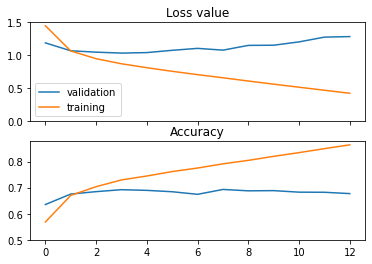

In [ ]:
records     = pd.read_csv(model_path +'.csv')
plt.figure()
plt.subplot(211)
plt.plot(records['val_loss'], label="validation")
plt.plot(records['loss'],label="training")
plt.yticks([0.00,0.50,1.00,1.50])
plt.title('Loss value',fontsize=12)

ax          = plt.gca()
ax.set_xticklabels([])

plt.subplot(212)
plt.plot(records['val_acc'],label="validation")
plt.plot(records['acc'],label="training")
plt.yticks([0.5,0.6,0.7,0.8])
plt.title('Accuracy',fontsize=12)
ax.legend()
plt.show()

In [ ]:
ingre_cnn.load_weights(model_path)
y_test = ingre_cnn.predict(x_test)
y_test = np.argmax(y_test,axis=1)

In [ ]:
id2label = dict(zip(range(class_num),label))

y_test = y_test.tolist()
y_label = [id2label[i] for i in y_test]



In [ ]:
print(label2id.keys())
test_data['cuisine'] = y_label
pd.set_option('display.max_colwidth',None)
test_data[test_data['Name'].str.contains('Gypsy')][['RecipeCategory','ingredients','Name','cuisine']].tail(20)

dict_keys(['moroccan', 'thai', 'irish', 'jamaican', 'cajun_creole', 'russian', 'mexican', 'spanish', 'chinese', 'greek', 'southern_us', 'italian', 'french', 'vietnamese', 'indian', 'korean', 'brazilian', 'japanese', 'british', 'filipino', 'unknown'])


,RecipeCategory,ingredients,Name,cuisine
240733,Cheese,"[cottage cheese, red bell pepper, carrot, apple, lemon juice, fresh parsley, Worcestershire sauce]",Gypsy Cheese Salad,japanese
270209,Vegetable,"[pearl barley, water, salt, olive oil, onion, garlic, flour, wine, soy sauce, paprika, thyme, cumin, cayenne, pepper, potatoes, carrots, green beans, broccoli florets, cabbage, celery, red pepper flakes, corn, fresh spinach]",Gypsy Soup,moroccan
281782,Beverages,"[irish cream, vodka]",Whistling Gypsy,italian
293842,Pork,"[boneless chicken breasts, pepper, paprika, flour, canola oil, mushrooms, onion, green bell pepper, red bell pepper, red wine, chicken broth, tomatoes, tomato paste, salt]",Zigeunerschnitzel (Gypsy Schnitzel),spanish
295770,None,"[marzipan, fine sugar, eggs, vanilla essence, salt, half-and-half, heavy cream, amaretto liqueur, fresh strawberries, fresh raspberries, frozen raspberries]",Lip Zmakk'in Gypsy Gelato,french
307829,Lunch/Snacks,"[red sweet bell peppers, swiss chard leaves, Worcestershire sauce, sugar, fresh mushrooms, olive oil, dry sherry, nutmeg, salt, artichoke hearts, coarse black pepper, lime juice, salt, gelatin]",The Gypsy Chicks' Summer Terrine for a Party!,italian
308581,Meat,"[onion, tomatoes, tomato paste, salt, chicken breasts, flour, eggs, olive oil]",Kotlety Po Cygansku - Gypsy Sznycel,italian
352483,Tarts,"[evaporated milk, dark muscovado sugar]",Gypsy Tart,southern_us
373782,Pork,"[bacon, bacon, onion, green bell pepper, garlic clove, all-purpose flour, sweet Hungarian paprika, beef broth, sauerkraut, dried marjoram, water]","Hungarian Egg Noodle, Sauerkraut, and Gypsy Bacon Soup",irish
383075,Dessert,"[eggs, sugar, water, baking powder, vanilla, flour]",Gypsy Arm (Brazo Gitano),southern_us


In [ ]:

set(train_data['cuisine'].tolist())

{'brazilian',
 'british',
 'cajun_creole',
 'chinese',
 'filipino',
 'french',
 'greek',
 'indian',
 'irish',
 'italian',
 'jamaican',
 'japanese',
 'korean',
 'mexican',
 'moroccan',
 'russian',
 'southern_us',
 'spanish',
 'thai',
 'vietnamese'}

In [ ]:
# test_data.head(2000).to_csv('/content/drive/MyDrive/IRSProjectSharedFolder/cuisine_pred_output.csv',index=None)

In [ ]:
def has_keyword(x):
  x = list(x)
  if x == [None]:
    return None
  for k in x:
    if k.lower() in geo_kw:
      return k
  return None

cuisine_df = test_data[['RecipeId','Name','Keywords','cuisine']].copy()
cuisine_df['cuisine_original'] = cuisine_df['Keywords'].apply(has_keyword)

In [ ]:

cuisine_df['cuisine_type'] = cuisine_df[['cuisine_original','cuisine']].apply(lambda row:row['cuisine'] if row['cuisine_original']==None else row['cuisine_original'].lower(),axis=1)
# cuisine_df[~cuisine_df['cuisine_original'].isnull()]
cuisine_df

,RecipeId,Name,Keywords,cuisine,cuisine_original,cuisine_type
0,38.0,Low-Fat Berry Blue Frozen Dessert,"[Dessert, Low Protein, Low Cholesterol, Healthy, Free Of..., Summer, Weeknight, Freezer, Easy]",southern_us,None,southern_us
1,39.0,Biryani,"[Chicken Thigh & Leg, Chicken, Poultry, Meat, Asian, Indian, Weeknight, Stove Top]",indian,Asian,asian
2,40.0,Best Lemonade,"[Low Protein, Low Cholesterol, Healthy, Summer, < 60 Mins]",french,None,french
3,41.0,Carina's Tofu-Vegetable Kebabs,"[Beans, Vegetable, Low Cholesterol, Weeknight, Broil/Grill, Oven]",japanese,None,japanese
4,42.0,Cabbage Soup,"[Low Protein, Vegan, Low Cholesterol, Healthy, Winter, < 60 Mins, Easy]",southern_us,None,southern_us
...,...,...,...,...,...,...
522512,541379.0,Meg's Fresh Ginger Gingerbread,[< 4 Hours],southern_us,None,southern_us
522513,541380.0,Roast Prime Rib au Poivre with Mixed Peppercorns,"[High Protein, High In..., < 4 Hours]",french,None,french
522514,541381.0,Kirshwasser Ice Cream,"[Dessert, < 4 Hours]",french,None,french
522515,541382.0,Quick & Easy Asian Cucumber Salmon Rolls,"[< 15 Mins, Easy]",japanese,None,japanese


#### generate cuisine type csv and cuisine_recipe relation csv

In [ ]:
ct_list = list(set(cuisine_df['cuisine_type'].to_list()))
ct_df = pd.DataFrame({':ID':ct_list,'Name':ct_list,':LABEL':'cuisine_type'})
ct_df

,:ID,Name,:LABEL
0,nigerian,nigerian,cuisine_type
1,lebanese,lebanese,cuisine_type
2,portuguese,portuguese,cuisine_type
3,belgian,belgian,cuisine_type
4,czech,czech,cuisine_type
...,...,...,...
60,tex mex,tex mex,cuisine_type
61,swiss,swiss,cuisine_type
62,austrian,austrian,cuisine_type
63,dutch,dutch,cuisine_type


In [ ]:
ct_df.to_csv('/content/drive/MyDrive/IRSProjectSharedFolder/neo4j_import_csv/cuisine_type.csv',index=None)

In [ ]:
cuisine_df[':START_ID'] = cuisine_df['RecipeId']
cuisine_df[':END_ID'] = cuisine_df['cuisine_type']
cuisine_df[':TYPE'] = 'Has_Cuisine_Type'
recipe_cuisine_type = cuisine_df[[':START_ID',':END_ID',':TYPE']]

In [ ]:
recipe_cuisine_type_header_csv=recipe_meal_type.drop(index=recipe_cuisine_type.index)
recipe_cuisine_type_header_csv

,:START_ID,:END_ID,:TYPE


In [ ]:
recipe_cuisine_type_header_csv.to_csv('/content/drive/MyDrive/IRSProjectSharedFolder/neo4j_import_csv/recipe_cuisine_type_header.csv',index=None)
recipe_cuisine_type.to_csv('/content/drive/MyDrive/IRSProjectSharedFolder/neo4j_import_csv/recipe_cuisine_type.csv',index=None,header=None)